In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-16 10:03:32.217290: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 10:03:32.249097: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-16 10:03:32.383611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 10:03:32.383654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 10:03:32.413108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced_paper.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,R80736,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,R80736,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,R80711,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,R80736,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0


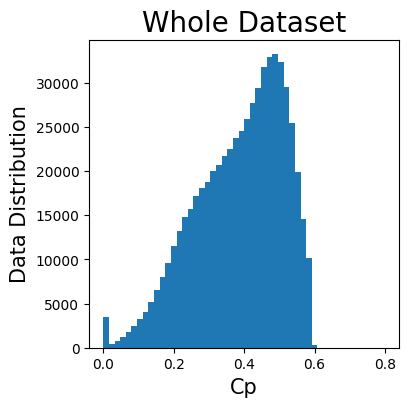

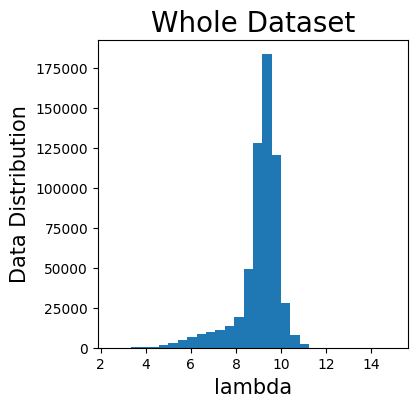

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,944.234446,19.290001,227.44,15.730000,20.680000,19.170000,19.920000,222.05,-5.37,7.27,1.801180,29.480000,222.05,222.05,10823.5,2043069.9,0.079908,3.707248
602645,959.131349,19.059999,227.44,15.600000,20.799999,19.299999,20.049999,221.98,-5.44,7.23,1.798038,29.379999,221.98,221.98,10843.5,2043060.1,0.078364,3.676787
602646,995.227747,17.000000,201.95,16.389999,21.010000,19.920000,20.469999,203.55,1.60,8.87,1.801180,32.730000,203.55,203.55,10853.3,2048070.1,0.073819,3.607639
602647,963.715011,16.000000,242.56,15.170000,21.120001,19.840000,20.480000,237.59,-4.99,9.31,1.801180,26.010000,237.59,237.59,10817.3,2041980.0,0.073492,3.605878
602648,1008.978735,17.000000,225.25,16.709999,21.280001,19.719999,20.500000,219.62,-5.62,10.31,1.799085,27.200001,219.62,219.62,10837.3,2043120.0,0.073318,3.598171


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-4.643517,342.545648,-61.879442,-57.295780,-56.722822,-51.566200,5.314757e+03
hub_temperature,602649.0,19.060174,5.838598,4.050000,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,180.414785,92.988829,0.000000,102.290000,200.679990,246.100010,3.600000e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.490000,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.000000,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.000000,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.230000,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,180.053769,92.830444,0.000000,102.270000,199.610000,245.160000,3.600000e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.340000,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.950000,5.960000,10.910000,16.330000,3.828000e+01


In [7]:
# Normalization 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
dataset_norm = dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        dataset_norm[col]=(dataset[col]-x_mean[icol])/x_std[icol]        
    else: # Cp in [0,1]
        dataset_norm[col]=dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -4.643517     342.545648
hub_temperature          19.060174       5.838598
nacelle_angle           180.414785      92.988829
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              180.053769      92.830444
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            179.627065      92.421807
nacelle_angle_c         179.767785      92.504951
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                             m

In [68]:
P_mean_data = dataset['P'].mean()
P_std_data = dataset['P'].std()
print(P_mean_data)
print(P_std_data)

444860.8792603868
446349.16524066305


In [38]:
# load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys.h5')
Pphys_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xphys (InputLayer)          [(None, 3)]                  0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['xphys[0][0]']               
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    17153     ['xphys[0][0]']               
                                                                                                  
 lambda_3 (Lambda)           (None, 1)                    0         ['lambda[0][0]',              
                                                                     'sequential_1[0][0]']    

18833/18833 [==============================] - 8s 445us/step


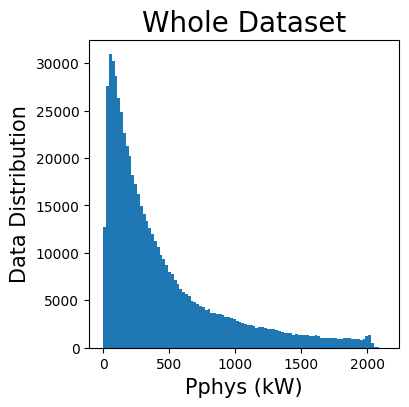

In [39]:
# Define input features of P_phys model
xphys = dataset_norm[['V','theta','W']]

# Evaluate power with normalized inputs
Pphys_data = Pphys_model.predict(xphys).flatten()

# Plot distribution of Pphys in kW
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
#plt.hist(Pphys_data/1000, range=[-100, 100], bins=100)
plt.hist(Pphys_data/1000, bins=100)
plt.xlabel('Pphys (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

In [65]:
# Split the data into training and test sets
""" train_dataset_x = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset_x = dataset_norm.drop(train_dataset_x.index)
train_dataset_y = dataset.sample(frac=0.8, random_state=10)
test_dataset_y = dataset.drop(train_dataset_y.index) """

train_dataset = dataset_norm.sample(frac=0.8, random_state=10)
test_dataset = dataset_norm.drop(train_dataset.index)

In [66]:
# Define input features of Pphys improved
""" train_features = train_dataset_x[['V','theta','W','Out_temperature']]
test_features = test_dataset_x[['V','theta','W','Out_temperature']]
train_labels = train_dataset_y.pop('P')
test_labels = test_dataset_y.pop('P') """

train_features = train_dataset[['V','theta','W','Out_temperature']]
test_features = test_dataset[['V','theta','W','Out_temperature']]
train_labels = train_dataset.pop('P')
test_labels = test_dataset.pop('P')

print(train_features.shape)
print(train_labels.shape)

(482119, 4)
(482119,)


In [72]:
from tensorflow.keras.models import Model

# Define the improved physical model

# Freeze pre-trained model layers so they are not updated during training
for layer in Pphys_model.layers:
    layer.trainable = False

# Define the input with shape (None, 4) for V, theta, W, and T
input_V_theta_W_T = layers.Input(shape=(4,), name='V_theta_W_T')

# Split the input into the first three elements (V, theta, W) and the fourth element (T)
input_V_theta_W = layers.Lambda(lambda x: x[:, :3], name='V_theta_W_split')(input_V_theta_W_T)  # First 3 elements
input_T = layers.Lambda(lambda x: x[:, 3:], name='T_split')(input_V_theta_W_T)  # Fourth element

# Get the pre-trained model output for Pphys(V, theta, W)
Pphys_output = Pphys_model(input_V_theta_W)
P_mean = tf.constant(P_mean_data, dtype=tf.float32)  # Example mean value
P_std = tf.constant(P_std_data, dtype=tf.float32)   # Example std deviation value
# Standardize Pphys_output
Pphys_output_standardized = (Pphys_output - P_mean) / P_std

# Define trainable parameters Ct and T0
#Ct = tf.Variable(-20000.0, trainable=True, dtype=tf.float32, name='Ct')   # Initialize Ct to 1.0
#T0 = tf.Variable(0.1, trainable=True, dtype=tf.float32, name='T0')   # Initialize T0 to 0.0
Ct = tf.Variable(1.0, trainable=True, dtype=tf.float32, name='Ct')   # Initialize Ct to 1.0
T0 = tf.Variable(0.1, trainable=True, dtype=tf.float32, name='T0')   # Initialize T0 to 0.0

# Define the new term Ct * (T - T0)
new_term = Ct * (input_T - T0)
#new_term = input_T-input_T

# The final output is the sum of Pphys(V, theta, W) and the new term
#final_output = layers.Add()([Pphys_output, new_term])
final_output = layers.Add()([Pphys_output_standardized, new_term])

# Create the full model
full_model = Model(inputs=input_V_theta_W_T, outputs=final_output)

# Compile the model
full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
#full_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Print the model summary to check the architecture
full_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 V_theta_W_T (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 V_theta_W_split (Lambda)    (None, 3)                    0         ['V_theta_W_T[0][0]']         
                                                                                                  
 model (Functional)          (None, 1)                    17153     ['V_theta_W_split[0][0]']     
                                                                                                  
 T_split (Lambda)            (None, 1)                    0         ['V_theta_W_T[0][0]']         
                                                                                           

In [73]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

batch_size = 128
history = full_model.fit(train_features, train_labels, epochs=10, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/10
3014/3014 [==============================] - 2s 662us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 2/10
3014/3014 [==============================] - 2s 637us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 3/10
3014/3014 [==============================] - 2s 641us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 4/10
3014/3014 [==============================] - 2s 651us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 5/10
3014/3014 [==============================] - 2s 644us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 6/10
3014/3014 [==============================] - 2s 650us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 7/10
3014/3014 [==============================] - 2s 640us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 8/10
3014/3014 [==============================] - 2s 647us/step - loss: 0.8448 - val_loss: 0.8462 - lr: 0.0010
Epoch 9/10
3014/3014 [==============================] - 2s 637us

In [74]:
# After training, retrieve the optimal values for Ct and T0
optimal_Ct = Ct.numpy()  # Get the optimal value for Ct
optimal_T0 = T0.numpy()  # Get the optimal value for T0

# Print the optimal values
print(f'Optimal value for Ct: {optimal_Ct}')
print(f'Optimal value for T0: {optimal_T0}')

Optimal value for Ct: 1.0
Optimal value for T0: 0.10000000149011612


Best epoch: 1


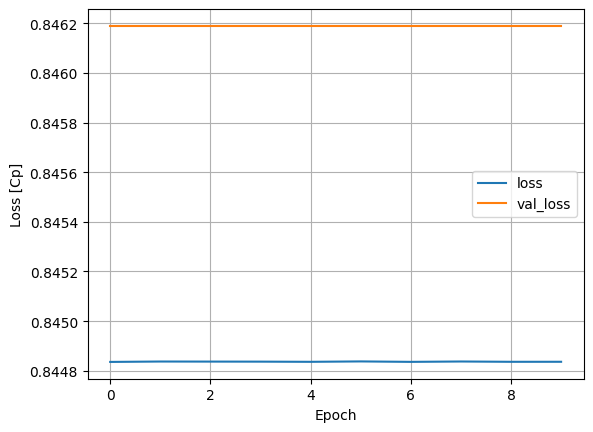

In [75]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cp]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

3767/3767 [==============================] - 2s 454us/step


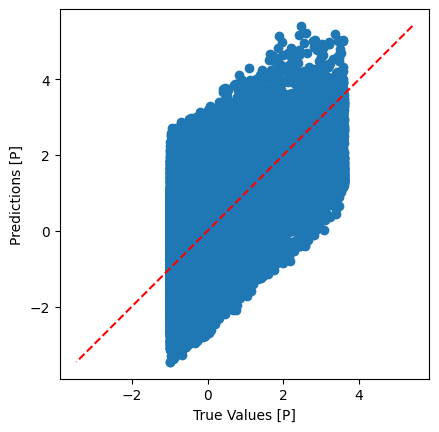

Test MAE: 0.8458207845687866


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [76]:
# Evaluate the model on P data

# Pred vs True values

#test_pred = model.predict(test_features[['lambda', 'theta']]).flatten()
test_pred = full_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
p1 = max(max(test_pred), max(test_labels))
p2 = min(min(test_pred), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

#test_result = model.evaluate(test_features[['lambda','theta']], test_labels, verbose=0)
test_result = full_model.evaluate(test_features, test_labels, verbose=0)
print("Test MAE: "+str(test_result))

# Metrics
y_pred = test_pred
y_true = test_labels
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))